<a href="https://colab.research.google.com/github/pranay414/cats-vs-dogs-pytorch/blob/master/cats_n_dogs_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import necessary libraries
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
# GPU check
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.8 GB  | Proc size: 213.2 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
# Helper function for displaying images and labels
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [4]:
# Get the dataset
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip

# Remove existing directories
!rm -r Cat_Dog_data __MACOSX || true
!unzip -qq Cat_Dog_data.zip

--2018-12-10 16:05:04--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.237.245
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.237.245|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
# Loading the cats and dogs dataset
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

data_dir = "Cat_Dog_data"

# Define transforms for the training and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

# Pass transforms here
train_data = datasets.ImageFolder(data_dir + "/train", transform = train_transforms)
test_data = datasets.ImageFolder(data_dir + "/test", transform = test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle = True)

In [6]:
# Examine a sample
data_iter = iter(trainloader)
images, labels = next(data_iter)
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


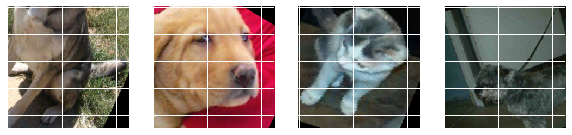

In [7]:
fig, axes = plt.subplots(figsize=(10, 4), ncols = 4)
for ii in range(4):
  ax = axes[ii]
  imshow(images[ii], ax = ax, normalize=False)

In [8]:
# Load the pre-trained model
model = models.resnet50(pretrained = True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:06<00:00, 15445912.03it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [9]:
# Freeze feature parameters
for param in model.parameters():
  param.requires_grad = False
  
classifier = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(512, 2),
                           nn.LogSoftmax(dim=1))

model.fc = classifier
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [10]:
# Training the model with feed forward network

model.cuda()

# Define epochs
epochs = 1

# Define optimizer
optimizer = optim.Adam(model.fc.parameters(), lr = 0.003)

# Define loss
criterion = nn.NLLLoss()

# Define running loss
running_loss = 0

# Define steps
step = 0
print_every = 5

for epoch in range(epochs):
  for inputs, labels in trainloader:
    step += 1
    
    # Shift computation to GPU
    inputs, labels = inputs.cuda(), labels.cuda()
  
    # Training pass
    optimizer.zero_grad()
  
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
  
    running_loss += loss.item()
    
    if step % print_every == 0:
      model.eval()
      test_loss = 0
      accuracy = 0
      
      for inputs, labels in testloader:
        # Shift computation to GPU
        inputs, labels = inputs.cuda(), labels.cuda()
        
        logps = model(inputs)
        loss = criterion(logps, labels)
        test_loss += loss.item()
        
        # Calculate accuracy
        ps = torch.exp(logps)
        top_ps, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
      print("Epoch: {}/{}..".format(epoch+1, epochs),
          "Training loss: {:.8f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.8f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.8f}".format(accuracy/len(testloader)))
      
      running_loss = 0
      model.train()

Epoch: 1/1.. Training loss: 0.01630620.. Test loss: 1.84944154.. Test Accuracy: 0.50276899
Epoch: 1/1.. Training loss: 0.00738904.. Test loss: 0.21191913.. Test Accuracy: 0.91099684
Epoch: 1/1.. Training loss: 0.00230228.. Test loss: 0.17323788.. Test Accuracy: 0.93473101
Epoch: 1/1.. Training loss: 0.00243063.. Test loss: 0.10192286.. Test Accuracy: 0.96479430
Epoch: 1/1.. Training loss: 0.00160946.. Test loss: 0.12631999.. Test Accuracy: 0.95530063
Epoch: 1/1.. Training loss: 0.00132475.. Test loss: 0.09319593.. Test Accuracy: 0.95965190
Epoch: 1/1.. Training loss: 0.00289330.. Test loss: 0.08213875.. Test Accuracy: 0.96756329
Epoch: 1/1.. Training loss: 0.00149873.. Test loss: 0.09389026.. Test Accuracy: 0.96558544
Epoch: 1/1.. Training loss: 0.00157548.. Test loss: 0.08829324.. Test Accuracy: 0.96637658
Epoch: 1/1.. Training loss: 0.00171376.. Test loss: 0.17564295.. Test Accuracy: 0.92958861
Epoch: 1/1.. Training loss: 0.00228862.. Test loss: 0.10075645.. Test Accuracy: 0.96083861

In [0]:
# Helper function view_classify to classify images into cats and dogs
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 224, 224).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(2), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    ax2.set_yticklabels(['Cat', 'Dog'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

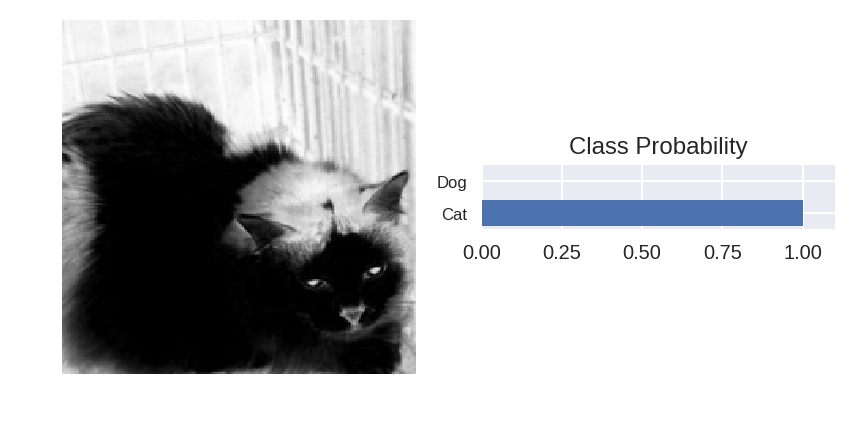

In [50]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Testing out the network
dataiter = iter(testloader)
images, labels = dataiter.next()

# Bring the model and test sample to CPU
model.cpu()
images, labels = images.cpu(), labels.cpu()

# Calculate the class probabilites (log softmax) for images
ps = torch.exp(model(images))

# Plot the image and probabilites
view_classify(images[0], ps[0])